# Python Multithreading vs Multiprocessing

This notebook presents examples of application of multithreading and multiprocessing in python, their pros and cons, and the most appropriate case scenarios for each.

Code is based on examples from [Python Documentation](https://docs.python.org/3/library/concurrent.futures.html)


In [1]:
import math
import time
import urllib.request
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor



addrs = ['http://www.poatek.com',
        'https://www.poatek.com/team/',
        'https://www.poatek.com/blog/',
        'https://www.poatek.com/our-method/',
        'https://www.poatek.com/services/',
        'https://en.wikipedia.org/wiki/Main_Page',
        'https://www.google.com/',
        'https://www.kaggle.com/competitions',
        'https://www.amazon.com/charts/mostread/fiction/',
        'https://www.amazon.com/charts/mostread/nonfiction',
        'https://www.amazon.com/charts/mostsold/nonfiction',
        'https://www.amazon.com/charts/mostsold/fiction',
        'https://www.nytimes.com',
        'https://www.bbc.com/',
        'https://www.lemonde.fr',
        'https://edition.cnn.com',
        ]

In [2]:
def multithreading(func, args, workers):
    with ThreadPoolExecutor(workers) as ex:
        res = ex.map(func, args)
    return list(res)


def multiprocessing(func, args, workers):
    with ProcessPoolExecutor(workers) as ex:
        res = ex.map(func, args)
    return list(res)

## Multithreading: I/O intensive tasks

I/O intensive programs can directly benefit from multithreading because their bottlenecks are usually reading and/or writing operations (or downloads in the case of web scrappers, for example).


In this example we will test a function that reads webpages and writes them on a local text file (we forced the file to be re-written a number of times to stress the execution).

In [3]:
def io_intensive(x):
    write_count = 50
    with urllib.request.urlopen(addrs[x], timeout=20) as conn:
        page = conn.read()
        for _ in range(write_count):
            with open('output.txt', 'w') as output:
                output.write(str(page))

def test_io_intensive_threads(thread_count_lst):
    times = []
    num_tasks = len(addrs)
    time_init = time.time()
    for i in range(num_tasks): 
        io_intensive(i)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Serial execution took {time_end - time_init}s.')
    for n_threads in thread_count_lst:
        time_init = time.time()
        multithreading(io_intensive, range(num_tasks), n_threads)
        time_end = time.time()
        times.append(float(time_end - time_init))
        print(f'Multithreading with {n_threads} threads took {time_end - time_init}s.')
    return times

Serial execution took 27.501050233840942s.
Multithreading with 2 threads took 12.876962900161743s.
Multithreading with 4 threads took 6.983922958374023s.
Multithreading with 8 threads took 5.409847974777222s.
Multithreading with 16 threads took 4.576305150985718s.


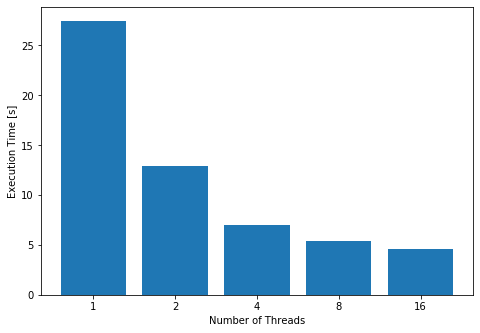

In [4]:
times = test_io_intensive_threads([2, 4, 8, 16])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Number of Threads')
ax.set_ylabel('Execution Time [s]')
num_threads = ['1', '2', '4', '8', '16']
ax.bar(num_threads, times)
plt.show()

If your internet connection is alright you should notice that we were able to reduce considerably the execution time of that code.

## Multiprocessing: CPU-intensive tasks (MacOS and Linux)


Programs that are CPU-bound will benefit from multiprocessing because their bottleneck is time and resources. Image and graphics processing are good examples, as they consist of huge amounts of math operations, that can often be divided into separate tasks because their data is independent. GPUs are the state-of-the-art hardware on this regard, being designed to process large chunks of data in parallel. 

**If you try to execute this code on windows, you will probably run into the following error:
``
BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.
``
Check the Windows solution below.**

In [5]:
def compute_intensive(x):
    foo = 0
    for i in range(10**7):
        foo += foo * math.cos(i*math.pi)
        
def test_compute_intensive():
    times = []
    num_tasks = 4
    time_init = time.time()
    for i in range(num_tasks): 
        compute_intensive(i)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Serial execution took {time_end - time_init}s.')
    n_threads = num_tasks
    time_init = time.time()
    multithreading(compute_intensive, range(num_tasks), n_threads)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Multithreading with {n_threads} threads took {time_end - time_init}s.')
    n_procs = num_tasks
    time_init = time.time()
    multiprocessing(compute_intensive, range(num_tasks), n_procs)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Multiprocessing with {n_procs} processes took {time_end - time_init}s.')
    return times

Serial execution took 9.170390844345093s.
Multithreading with 4 threads took 9.751523971557617s.
Multiprocessing with 4 processes took 6.076887845993042s.


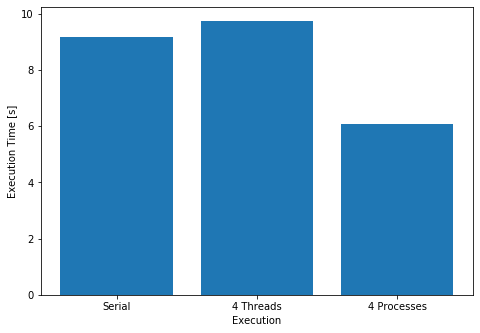

In [6]:
times = test_compute_intensive()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Execution')
ax.set_ylabel('Execution Time [s]')
num_threads = ['Serial', '4 Threads', '4 Processes']
ax.bar(num_threads, times)
plt.show()

## Multiprocessing: CPU-intensive tasks (Windows)

If you try to execute the code above on windows, you will probably run into the following error:
``
BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.
``


That is because of how Windows handles processes. UNIX operating systems (such as Linux and MacOS) use a function called fork() to create new processes. Windows doesn't have os.fork(), so it tries to emulate it in a very stupid way: it just copies the mother-process.. 
We have to make some changes to our code to guarantee we can execute it on windows without an error or an infinite loop.
Basically, we have to create a way for the the child process to run our desired code again, distinguishing the parent process and the child process. We can do it surrouding our original process with the ``if __name__ == '__main__'`` statement, and putting the worker function in a separate file.


In [ ]:
from multiprocessing import Pool, freeze_support
import windows_worker_cpu

def test_compute_intensive():
    times = []
    num_tasks = 4
    time_init = time.time()
    for i in range(num_tasks): 
        windows_worker_cpu.compute_intensive(i)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Serial execution took {time_end - time_init}s.')
    n_threads = num_tasks
    time_init = time.time()
    multithreading(windows_worker_cpu.compute_intensive, range(num_tasks), n_threads)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Multithreading with {n_threads} threads took {time_end - time_init}s.')
    n_procs = num_tasks
    time_init = time.time()
    multiprocessing(windows_worker_cpu.compute_intensive, range(num_tasks), n_procs)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Multiprocessing with {n_procs} processes took {time_end - time_init}s.')
    return times
    

if __name__ == '__main__':
    times = test_compute_intensive()
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel('Execution')
    ax.set_ylabel('Execution Time [s]')
    num_threads = ['Serial', '4 Threads', '4 Processes']
    ax.bar(num_threads, times)
    plt.show()

Serial execution took 11.304417133331299s.


It shall be clear from this example that multithreading just not able to achieve any speedup for this type of application.
That is because GIL assures only one thread is executed in the CPU at a given time.

## Multiprocessing on I/O intensive tasks

We have not tested multiprocessing on I/O intesive functions. Even thougt it is, in theory, a waste of resources to dedicate a process to a I/O-bound task, there should be no reason for multiprocessing to be unable to achieve speedups in this use case.

Let's check it out:


In [7]:
def test_io_intensive_processes(proc_count_lst):
    times = []
    num_tasks = len(addrs)
    time_init = time.time()
    for i in range(num_tasks): 
        io_intensive(i)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Serial execution took {time_end - time_init}s.')
    for n_procs in proc_count_lst:
        time_init = time.time()
        multiprocessing(io_intensive, range(num_tasks), n_procs)
        time_end = time.time()
        times.append(float(time_end - time_init))
        print(f'Multiprocessing with {n_procs} processes took {time_end - time_init}s.')
    return times

Serial execution took 32.81246590614319s.
Multiprocessing with 2 processes took 20.938379049301147s.
Multiprocessing with 4 processes took 7.687211990356445s.
Multiprocessing with 8 processes took 7.925058126449585s.


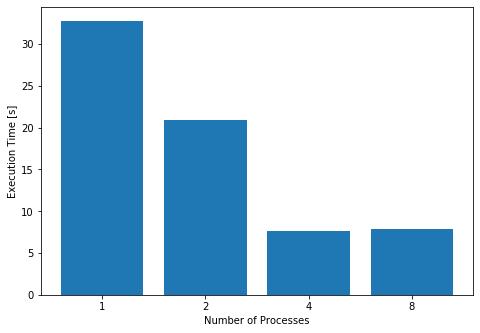

In [8]:
times = test_io_intensive_processes([2, 4, 8])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Number of Processes')
ax.set_ylabel('Execution Time [s]')
num_threads = ['1', '2', '4', '8']
ax.bar(num_threads, times)
plt.show()

As expected, multiprocessing could also deliver speedup for an IO-bound task. You may however notice that threads are still the best option for that case. That is because proccesses have a much higher initialization cost that may compromise their performance. Also, as discussed before, the number of process you can have execution in parallel is limited by the number of processing cores of the machine you are using.